In [1]:
import pandas as pd
from utils import simulate_system, negative_log_likelihood, negative_log_likelihood_sim, euler, euler_sim
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

df = pd.read_csv('data/real_estate.csv')

df['price_scaled'] = df['price'] / df['price'].max()
df['interest_rate_scaled'] = df['interest_rate'] / df['interest_rate'].max()
df['house_age_scaled'] = df['house_age'] / df['house_age'].max()
df['distance_from_mrt_scaled'] = df['distance_from_mrt'] / df['distance_from_mrt'].max()
df['n_of_conv_stores_scaled'] = df['n_of_conv_stores'] / df['n_of_conv_stores'].max()

df.head()

,date,house_age,distance_from_mrt,n_of_conv_stores,latitude,longtitude,price,interest_rate,price_scaled,interest_rate_scaled,house_age_scaled,distance_from_mrt_scaled,n_of_conv_stores_scaled
0,2012-09-01,12.6,383.2805,7,24.96735,121.54464,42.5,1.88,0.220207,0.494737,0.160920,0.059075,0.7
1,2012-09-01,29.4,4510.3590,1,24.94925,121.49542,13.2,1.88,0.068394,0.494737,0.375479,0.695183,0.1
2,2012-09-01,3.1,577.9615,6,24.97201,121.54722,47.7,1.88,0.247150,0.494737,0.039591,0.089081,0.6
3,2012-09-01,1.1,329.9747,5,24.98254,121.54395,51.8,1.88,0.268394,0.494737,0.014049,0.050859,0.5
4,2012-09-01,37.1,918.6357,1,24.97198,121.55063,31.9,1.88,0.165285,0.494737,0.473819,0.141590,0.1


In [2]:
bounds = [
    (-10, 10),  # Bounds for alpha0
    (-10, 10),  # Bounds for alpha1
    (-10, 10),  # Bounds for alpha2
    (-10, 10),  # Bounds for alpha3
    (-10, 10),  # Bounds for beta0
    (-10, 10),  # Bounds for beta1
    (-10, 10),  # Bounds for beta2
    (0.01, 10)  # Bounds for sigma (must be positive)
]

# Set options for the optimization process
options = {
    'maxiter': 10000,      # Increase the maximum number of iterations
    'disp': True,          # Display convergence messages
    'ftol': 1e-9,          # Set a small tolerance for function value
    'gtol': 1e-9,          # Set a small tolerance for gradient value
    'eps': 1e-5            # Step size for numerical approximations
}

In [ ]:
features = df[['interest_rate_scaled', 'house_age_scaled', 'distance_from_mrt_scaled', 'n_of_conv_stores_scaled']]
z0 = df['price_scaled'].values[0]
T = len(df)
dt = 1
initial_guess = np.random.uniform(-5, 5, size=(8,))

result = minimize(negative_log_likelihood, initial_guess, args=(df, features, z0, T, dt), method='L-BFGS-B', bounds=bounds, options=options)

alpha0_est, alpha1_est, alpha2_est, alpha3_est, beta0_est, beta1_est, beta2_est, sigma_est = result.x

In [4]:
print(f"Estimated alpha0: {alpha0_est}, Estimated alpha1: {alpha1_est}, Estimated alpha2: {alpha2_est}, Estimated alpha3: {alpha3_est}")
print(f"Estimated beta0: {beta0_est}, Estimated beta1: {beta1_est}, Estimated beta2: {beta2_est}")
print(f"Estimated sigma: {sigma_est}")

Estimated alpha0: -1.776144095761075, Estimated alpha1: 1.8187992848634256, Estimated alpha2: 4.526941397666176, Estimated alpha3: 4.3519555585028
Estimated beta0: 3.7549495083044313, Estimated beta1: -0.08622192012902552, Estimated beta2: 2.1197197787084407
Estimated sigma: 0.01


In [5]:
alpha_est_series = alpha0_est + alpha1_est * features['interest_rate_scaled'] + alpha2_est * features['house_age_scaled'] + alpha3_est * features['distance_from_mrt_scaled']
beta_est_series = beta0_est + beta1_est * features['interest_rate_scaled'] + beta2_est * features['n_of_conv_stores_scaled']

z_estimated = euler(alpha_est_series, beta_est_series, sigma_est, z0, T, dt)

In [6]:
z_estimated = np.clip(z_estimated, -500, 500)

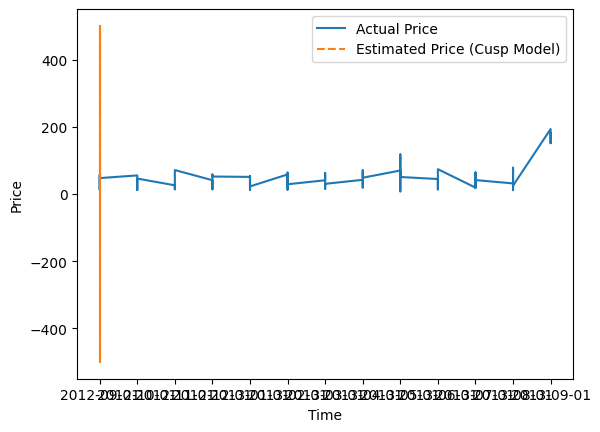

In [7]:
plt.plot(df['date'], df['price'], label='Actual Price')
plt.plot(df['date'], z_estimated, label='Estimated Price (Cusp Model)', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

True alpha: 1, Estimated alpha: 0.10000074561505502
True beta: 1.0, Estimated beta: 0.10000018751746248
True sigma: 0.2, Estimated sigma: 0.10000091419891369


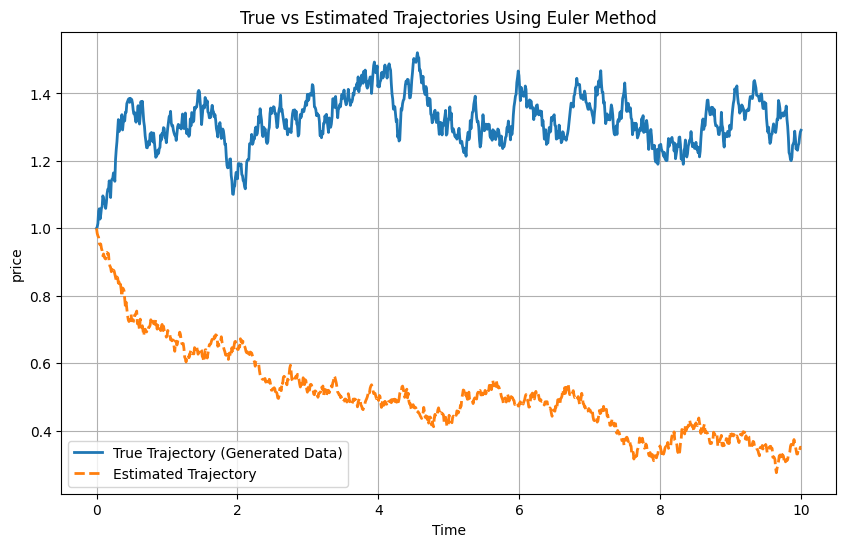

In [9]:
%matplotlib inline

alpha_true = 1
beta_true = 1.0
sigma_true = 0.2
z0 = 1.0
T = 10
dt = 0.01

z_data = simulate_system(alpha_true, beta_true, sigma_true, z0, T, dt)
initial_guess = [0.1, 0.1, 0.1]

result = opt.minimize(negative_log_likelihood_sim, initial_guess, args=(z_data, z0, T, dt), method='L-BFGS-B')

alpha_est, beta_est, sigma_est = result.x

print(f"True alpha: {alpha_true}, Estimated alpha: {alpha_est}")
print(f"True beta: {beta_true}, Estimated beta: {beta_est}")
print(f"True sigma: {sigma_true}, Estimated sigma: {sigma_est}")

z_estimated = euler_sim(alpha_est, beta_est, sigma_est, z0, T, dt)
time_points = np.linspace(0, T, len(z_data))

plt.figure(figsize=(10, 6))
plt.plot(time_points, z_data, label='True Trajectory (Generated Data)', linewidth=2)
plt.plot(time_points, z_estimated, label='Estimated Trajectory', linestyle='--', linewidth=2)
plt.xlabel("Time")
plt.ylabel("price")
plt.title("True vs Estimated Trajectories Using Euler Method")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
from utils import cusp_pdf, negative_log_likelihood_cobb, predict_prices

In [11]:
features_scaled = df[['interest_rate_scaled', 'house_age_scaled', 'distance_from_mrt_scaled', 'n_of_conv_stores_scaled']]

z0 = df['price_scaled'].values[0]
initial_guess = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [12]:
result = minimize(negative_log_likelihood_cobb, initial_guess, args=(df, features_scaled), method='L-BFGS-B')

In [13]:
alpha0_est, alpha1_est, alpha2_est, alpha3_est, beta0_est, beta1_est, beta2_est = result.x

In [14]:
print(f"Estimated alpha0: {alpha0_est}, Estimated alpha1: {alpha1_est}, Estimated alpha2: {alpha2_est}, Estimated alpha3: {alpha3_est}")
print(f"Estimated beta0: {beta0_est}, Estimated beta1: {beta1_est}, Estimated beta2: {beta2_est}")


Estimated alpha0: 4329.941252528798, Estimated alpha1: 1652.1814564670512, Estimated alpha2: -368.22481721367996, Estimated alpha3: 815.6535146027076
Estimated beta0: -329.7738041328134, Estimated beta1: -417.3912849691146, Estimated beta2: -142.33812416636096


In [15]:
alpha_est_series = (
    alpha0_est + 
    alpha1_est * features_scaled['interest_rate_scaled'] + 
    alpha2_est * features_scaled['house_age_scaled'] + 
    alpha3_est * features_scaled['distance_from_mrt_scaled']
)
beta_est_series = (
    beta0_est + 
    beta1_est * features_scaled['interest_rate_scaled'] + 
    beta2_est * features_scaled['n_of_conv_stores_scaled']
)

In [16]:
predicted_prices = predict_prices(alpha_est_series, beta_est_series)
predicted_prices_unscaled = predicted_prices * df['price'].max()

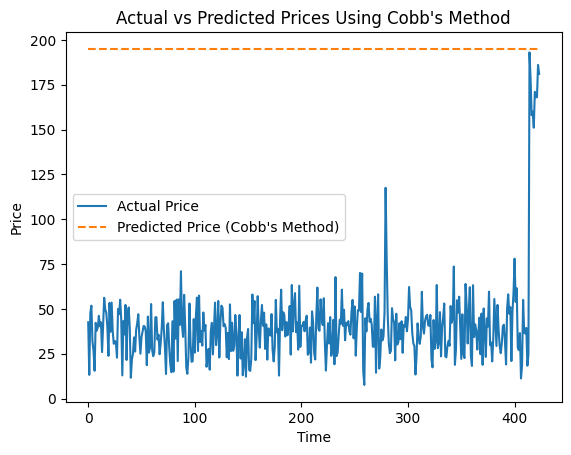

In [17]:
plt.plot(df['price'], label='Actual Price')
plt.plot(predicted_prices_unscaled, label='Predicted Price (Cobb\'s Method)', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices Using Cobb\'s Method')
plt.legend()
plt.show()

True alpha: 1, Estimated alpha: 307.7977423171683
True beta: 1.0, Estimated beta: 232404.15530118498
True sigma: 0.2, Estimated sigma: 0.1


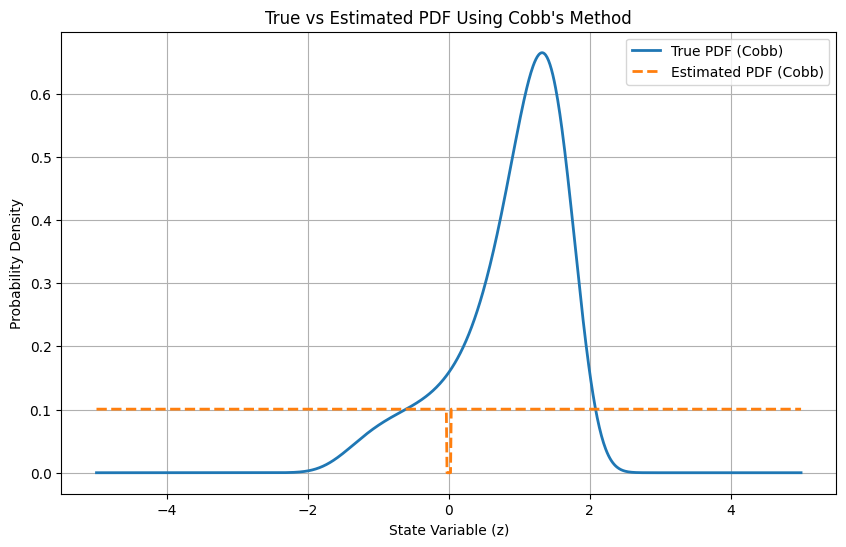

In [20]:
%matplotlib inline

from utils import cobb_simulate, negative_log_likelihood_cobb_sim, normalize_pdf

alpha_true = 1
beta_true = 1.0
sigma_true = 0.2
n_samples = 1000

z_data_cobb = cobb_simulate(alpha_true, beta_true, n_samples)

initial_guess = [0.1, 0.1, 0.1]
result_cobb = minimize(negative_log_likelihood_cobb_sim, initial_guess, args=(z_data_cobb,), method='L-BFGS-B')

alpha_est, beta_est, sigma_est = result_cobb.x

print(f"True alpha: {alpha_true}, Estimated alpha: {alpha_est}")
print(f"True beta: {beta_true}, Estimated beta: {beta_est}")
print(f"True sigma: {sigma_true}, Estimated sigma: {sigma_est}")

z_values = np.linspace(-5, 5, 1000)
true_pdf_values = cusp_pdf(z_values, alpha_true, beta_true) / normalize_pdf(alpha_true, beta_true)
estimated_pdf_values = cusp_pdf(z_values, alpha_est, beta_est) / normalize_pdf(alpha_est, beta_est)

plt.figure(figsize=(10, 6))
plt.plot(z_values, true_pdf_values, label='True PDF (Cobb)', linewidth=2)
plt.plot(z_values, estimated_pdf_values, label='Estimated PDF (Cobb)', linestyle='--', linewidth=2)
plt.xlabel("State Variable (z)")
plt.ylabel("Probability Density")
plt.title("True vs Estimated PDF Using Cobb's Method")
plt.legend()
plt.grid(True)
plt.show()